In [3]:
import numpy as np
import torch
import os
import sys
import math
from matplotlib import pyplot as plt
from sklearn.metrics import average_precision_score, roc_auc_score
from torch import nn
from torch.nn import functional as F
from tqdm import trange, tqdm
from utils import *
from modules import *
import torchvision
from torchvision import datasets, transforms

In [4]:
JITTER = 1e-6
torch.manual_seed(0)

In [27]:
class BayesianLayer(torch.nn.Module):
    '''
    Module implementing a single Bayesian feedforward layer.
    The module performs Bayes-by-backprop, that is, mean-field
    variational inference. It keeps prior and posterior weights
    (and biases) and uses the reparameterization trick for sampling.
    '''
    def __init__(self, input_dim, output_dim, prior_mu=0, prior_sigma=0.1, bias=True):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = bias

        # TODO: enter your code here
        self.prior_mu = prior_mu
        self.prior_sigma = prior_sigma
        self.prior_logsigma = math.log(self.prior_sigma)

        self.weight_mu = nn.Parameter(torch.Tensor(self.output_dim, self.input_dim))
        self.weight_logsigma = nn.Parameter(torch.Tensor(self.output_dim, self.input_dim))
        self.register_buffer('weight_eps', None)

        if self.use_bias:
            self.bias_mu = nn.Parameter(torch.zeros(output_dim))
            self.bias_logsigma = nn.Parameter(torch.zeros(output_dim))
            self.register_buffer('bias_eps', None)
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_logsigma', None)
            
        self.init_parameters()
            
    def init_parameters(self):
        stdv = 1. / math.sqrt(self.weight_mu.size(1))
        stdv = 0.1
        self.weight_mu.data.uniform_(-stdv, stdv)
        self.weight_logsigma.data.fill_(self.prior_logsigma)
        if self.use_bias :
            self.bias_mu.data.uniform_(-stdv, stdv)
            self.bias_logsigma.data.fill_(self.prior_logsigma)

    def forward(self, inputs):
        weight = self.weight_mu + (torch.exp(self.weight_logsigma) + JITTER) * torch.randn_like(self.weight_logsigma)
        bias = None
        if self.use_bias:
            bias = self.bias_mu + (torch.exp(self.bias_logsigma) + JITTER) * torch.randn_like(self.bias_logsigma)

        return F.linear(inputs, weight, bias)

    def kl_divergence(self):
        '''
        Computes the KL divergence between the priors and posteriors for this layer.
        '''
        kl_loss = self._kl_divergence(self.weight_mu, self.weight_logsigma)
        if self.use_bias:
            kl_loss_bias = self._kl_divergence(self.bias_mu, self.bias_logsigma)
            kl_loss += kl_loss_bias

        return kl_loss

    def _kl_divergence(self, mu, logsigma):
        '''
        Computes the KL divergence between one Gaussian posterior
        and the Gaussian prior.
        '''
        # TODO: enter your code here
        kl = logsigma - self.prior_logsigma + \
            (math.exp(self.prior_logsigma)**2 + (self.prior_mu - mu)**2) / (2*torch.exp(logsigma)**2) - 0.5

        return kl.mean()

In [18]:
class BayesNet(torch.nn.Module):
    '''
    Module implementing a Bayesian feedforward neural network using
    BayesianLayer objects.
    '''
    def __init__(self, input_size, num_layers, width, prior_mu=0, prior_sigma=0.1,):
        super().__init__()
        self.output_dim = 10
        
        if type(width) == list:
            input_layer = torch.nn.Sequential(BayesianLayer(input_size, width[0], prior_mu, prior_sigma),
                                           nn.ReLU())
            hidden_layers = []
            for i in range(len(width)-1):
                hidden_layers.append(
                    torch.nn.Sequential(BayesianLayer(width[i], width[i+1], prior_mu, prior_sigma))
                )
            output_layer = BayesianLayer(width[-1], self.output_dim, prior_mu, prior_sigma)
        else:
            input_layer = torch.nn.Sequential(BayesianLayer(input_size, width, prior_mu, prior_sigma),
                                           nn.ReLU())
            hidden_layers = [nn.Sequential(BayesianLayer(width, width, prior_mu, prior_sigma),
                                nn.ReLU()) for _ in range(num_layers)]
            output_layer = BayesianLayer(width, self.output_dim, prior_mu, prior_sigma)
        
        layers = [input_layer, *hidden_layers, output_layer]
        self.net = torch.nn.Sequential(*layers)
        
    def save(self, file_path='bayesnet.pt'):
        print("Saving BayesNet model to ", file_path)
        torch.save(self.net, file_path)

    def forward(self, x):
        x = x.squeeze()
        return self.net(x)

    def predict_class_probs(self, x, num_forward_passes=10):
        x = x.squeeze()
        assert x.shape[1] == 28**2
        batch_size = x.shape[0]

        # TODO: make n random forward passes
        # compute the categorical softmax probabilities
        # marginalize the probabilities over the n forward passes
        probs = x.data.new(num_forward_passes, x.shape[0], self.output_dim)
        for i in range(num_forward_passes):
            y = self.forward(x)
            probs[i] = y
        # average over the num_forward_passes dimensions
        probs = probs.mean(dim=0, keepdim=False)

        assert probs.shape == (batch_size, 10)
        return F.softmax(probs, dim=1)

    def kl_loss(self, reduction='mean'):
        '''
        Computes the KL divergence loss for all layers.
        '''
        # TODO: enter your code here
        kl = torch.Tensor([0])
        kl_sum = torch.Tensor([0])
        n = torch.Tensor([0])

        for m in self.modules():
            if isinstance(m, (BayesianLayer)):
                kl = m.kl_divergence()
                kl_sum += kl
                n += len(m.weight_mu.view(-1))
                if m.use_bias:
                    n += len(m.bias_mu.view(-1))
        if reduction == 'mean':
            return kl_sum/n
        elif reduction == 'sum':
            return kl_sum
        else:
            raise ValueError("Error: {0} is not a valid reduction method".format(reduction))

In [19]:
def train_network(model, optimizer, train_loader, num_epochs=100, pbar_update_interval=100, kl_weight=1):
    '''
    Updates the model parameters (in place) using the given optimizer object.
    Returns `None`.

    The progress bar computes the accuracy every `pbar_update_interval`
    iterations.
    '''
    criterion = torch.nn.CrossEntropyLoss() # always used in this assignment

    pbar = trange(num_epochs)
    for i in pbar:
        for k, (batch_x, batch_y) in enumerate(train_loader):
            batch_x = batch_x.squeeze()
            model.zero_grad()
            optimizer.zero_grad()
            y_pred = model(batch_x)
            loss = criterion(y_pred, batch_y)

            if type(model) == BayesNet:
                # BayesNet implies additional KL-loss.
                # TODO: enter your code here
                kl_loss = model.kl_loss()
                loss = loss + kl_weight * kl_loss

            loss.backward()
            optimizer.step()

            if k % pbar_update_interval == 0:
                acc = (model(batch_x).argmax(axis=1) == batch_y).sum().float()/(len(batch_y))
                pbar.set_postfix(loss=loss.item(), acc=acc.item())

In [20]:
batch_size = 256  # Try playing around with this
mnist_rotation_angle = 50

/home/yannick/.local/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


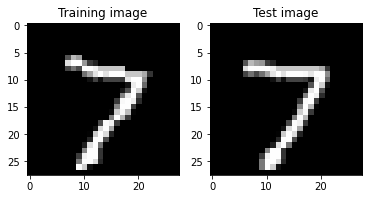

In [21]:
# create train set
dataset_train = load_rotated_mnist()
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                           shuffle=True, drop_last=True)

# generate a custom rotated test set
transformOpt = transforms.Compose([
            transforms.RandomRotation(degrees=(mnist_rotation_angle, -mnist_rotation_angle)),
            transforms.ToTensor(),
            Img2dTo1d(28**2)
])
test_set = datasets.MNIST(
        root='', train=False, transform=transformOpt, download=True)
test_loader = torch.utils.data.DataLoader(
        dataset=test_set,
        batch_size=100,
        shuffle=False)

train_images, train_labels = next(iter(test_loader))
test_images, test_labels = next(iter(test_loader))
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Training image")
ax1.imshow(train_images[0].view(28, 28), cmap="gray")
ax2.set_title("Test image")
ax2.imshow(test_images[0].view(28, 28), cmap="gray")
fig.show()

In [56]:
prior_mu = 0
prior_sigma = 0.11
num_layers = 3
width = 75
num_epochs = 150 # You might want to adjust this
print_interval = 100
learning_rate = 1e-4  # Try playing around with this
extended_evaluation = True  # Set this to True for additional model evaluation
kl_weight = 2

In [57]:
private_test = None
model_type = "bayesnet"  # Try changing this to "densenet" as a comparison
if model_type == "bayesnet":
    model = BayesNet(input_size=784, num_layers=num_layers, width=width, prior_mu=prior_mu, prior_sigma=prior_sigma)
elif model_type == "densenet":
    model = Densenet(input_size=784, num_layers=num_layers, width=width)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_network(model, optimizer, train_loader,
             num_epochs=num_epochs, pbar_update_interval=print_interval, kl_weight=kl_weight)

if test_loader is None:
    print("evaluating on train data")
    test_loader = train_loader
else:
    print("evaluating on test data")

# Do not change this! The main() method should return the predictions for the test loader
predictions = evaluate_model(model, model_type, test_loader, batch_size, extended_evaluation, private_test)

  1%|▏         | 2/150 [00:12<15:49,  6.41s/it, acc=0.0781, loss=2.35]


KeyboardInterrupt: 

Baseline: acc = 0.729, ECE = 0.126, score = 1.85

In [48]:
score(0.728, 0.126)

1.8499999999999999

In [16]:
torch.save(model.state_dict(), "models/bn_3x50_m0s01_kl2.pt")